In [1]:
# Proof of concept implementation

In [2]:
import typing
import io
import os
import sys
import json
import torch
import torchvision
import cv2
import png
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlretrieve
from PIL import Image
from torchvision import transforms
from torchvision import models
import torchvision.transforms.functional as F
import torchvision.transforms as T
from matplotlib import cm
from vit_models.modeling import VisionTransformer, CONFIGS
import timm
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [3]:
# Prepare labels and download ViT model
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [4]:
# Data loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


batch_size = 1
testset = torchvision.datasets.ImageFolder(root='./data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
dataiter = iter(testloader)

In [5]:
# Helper functions for images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def tensor_to_image(img):
    img = img / 2 + 0.5 # unnormalize
    img = transforms.ToPILImage('RGB')(img.squeeze_(0))
    return img

In [31]:
# Prepare Vision Transformer and helper functions
# Attention map visualization adapted from https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

def plot_attention_map(logits, att_mat, image):

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    # ax1.set_title('Original')
    # ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(result)

    probs = torch.nn.Softmax(dim=-1)(logits)
    top5 = torch.argsort(probs, dim=-1, descending=True)
    for idx in top5[0, :5]:
        print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

def vit_eval(image):
    x = transform(image)
    logits, att_mat = model(x.unsqueeze(0))
    plot_attention_map(logits, att_mat, image)
    

In [51]:
# Prepare BigTransfer ResNet model
resnet_model = timm.create_model('resnetv2_101x1_bitm', pretrained=True)

def resnet_eval(image): 
    tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        out = resnet_model(tensor)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)

    url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
    urllib.request.urlretrieve(url, filename) 
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Print top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(top5_prob[i].item(), categories[top5_catid[i]])

In [52]:
# Segmentation
# Code adapted from https://github.com/spmallick/learnopencv/blob/master/app-seperation-semseg/Background-Removal.py

def decode_segmap(image, source, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
   

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
  
    rgb = np.stack([r, g, b], axis=2)

    # Load the foreground input image 
    foreground = source

    # Change the color of foreground image to RGB 
    # and resize image to match shape of R-band in RGB output map
    #foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(np.array(foreground),(r.shape[1],r.shape[0]))

    # Create a background array to hold white pixels
    # with the same size as RGB output map
    background = 255 * np.ones_like(rgb).astype(np.uint8)

    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7,7),0)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)  
  
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)  

    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    return outImage/255

def segment(net, image, show_orig=True, dev='cpu'):
    img = image
    original_size = img.height
    
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(original_size), 
                   # Comment CenterCrop out
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
    rgb = decode_segmap(om, img)
    #plt.axis('off'); 
    image = Image.fromarray((rgb * 255).astype(np.uint8))
    return image

---- Original ViT----
0.85558 : starfish, sea_star
0.10838 : sea_anemone, anemone
0.02152 : sea_urchin
0.00247 : coral_reef
0.00126 : sea_cucumber, holothurian
---- Original Resnet----
0.5751294493675232 starfish
0.0852806568145752 goldfish
0.051043473184108734 sea urchin
0.04119240865111351 sea anemone
0.01550483237951994 sea slug


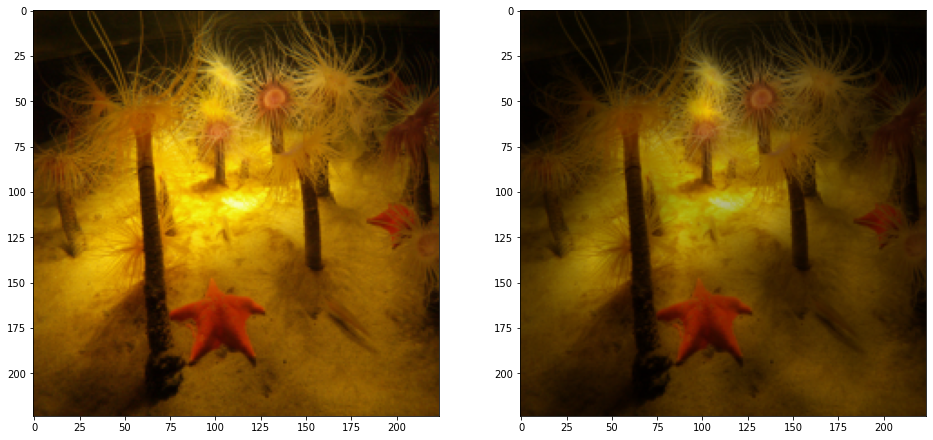

In [53]:
# Begin of pipeline, run this cell again to evaluate a new images
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

image, label = dataiter.next()
image = image / 2 + 0.5 # unnormalize
image = transforms.ToPILImage('RGB')(image.squeeze_(0))
print('---- Original ViT----')
vit_eval(image)
print('---- Original Resnet----')
resnet_eval(image)

---- Segmentation ViT----
0.03130 : bassoon
0.03127 : nail
0.02025 : oboe, hautboy, hautbois
0.01921 : matchstick
0.01817 : syringe
---- Segmentation ResNet----
0.34822404384613037 tick
0.24152609705924988 chiffonier
0.09756298363208771 ant
0.0420340895652771 mortar
0.03810887038707733 nail


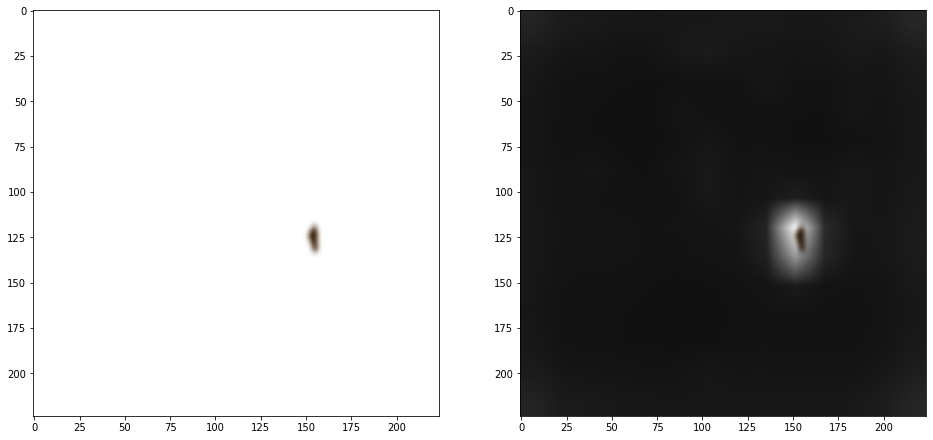

In [54]:
segmented_img = segment(dlab, image, show_orig=False)
print('---- Segmentation ViT----')
vit_eval(segmented_img)
print('---- Segmentation ResNet----')
resnet_eval(segmented_img)

In [ ]:
tensor = transform(image).unsqueeze(0)
with torch.no_grad():
    out = resnet_model(tensor)
probabilities = torch.nn.functional.softmax(out[0], dim=0)

url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Print top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

In [ ]:
# Load pretrained YOLOv5 Object Detector
detector_model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True).autoshape()

In [ ]:
results = detector_model(image, size=640)
results.print()
results.show()

In [ ]:
# Evaluate bounding boxes
results.pandas().xyxy
print(results.xyxy)

In [ ]:
# Get bounding box coordinates from detections and choose one for evaluation

#     
x1 = int(results.xyxy[0][0][0])
y1 = int(results.xyxy[0][0][1])
x2 = int(results.xyxy[0][0][2])
y2 = int(results.xyxy[0][0][3])
bbox_points=[x1, y1, x2, y2]
print('bounding box is:', x1, y1, x2, y2)

# Show cropped image (bounding box)
cropped_img = image.crop((x1, y1, x2, y2))
display(cropped_img)

In [ ]:
print('---- Cropped ----')
evaluate(cropped_img)

In [ ]:
print('---- Cropped and segmented ----')
cropped_segmented_img = segment(dlab, cropped_img, show_orig=False)
evaluate(cropped_segmented_img)